# PNSN Tremor database
## mat file is Ken Creager's analysis for extracting ETS tremor 'swarms'

There are 1793 in this catalog between July 2004 and July 2017

Each swarm has centroid statistics, and a lookuptable to plot all instances of tremor associated with that swarm

## Matlab file structure is as follows:
TREMall = 

          n: [393765x1 double]
        lat: [393765x1 double]
        lon: [393765x1 double]
        err: [393765x1 double]
        dep: [393765x1 double]
    err_dep: [393765x1 double]


Summary = 

               N: [1793x1 double]
           Hours: [1793x1 double]
               n: {1793x1 cell}
           ktrem: {1793x1 cell}
             lat: [1793x1 double]
             lon: [1793x1 double]
          latDev: [1793x1 double]
          lonDev: [1793x1 double]
         TimeWin: [1793x2 double]
         EventNo: [1793x1 double]
    StartDateStr: {1793x1 cell}
        Duration: [1793x1 double]

In [279]:
import scipy.io as sio
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

plt.style.use('seaborn-white')
%matplotlib notebook

#%qtconsole

In [27]:
matFile = '/Users/scott/Desktop/SummaryLatest.mat'
mat = sio.loadmat(matFile)

In [28]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Summary', 'TREMall', 'cluster_min', 'clustr', 'd_max', 'n_max'])

In [29]:
mat['__header__']

b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Jul 13 14:39:39 2017'

In [30]:
summary = mat['Summary']

In [108]:
def matlabDate2python(matdate):
    pydate = datetime.datetime.fromordinal(int(matdate) - 366) + datetime.timedelta(days=matdate%1)
    return pydate

In [180]:
# dtypes not converted correctly, but easy enough to convert:
N = summary['N'][0][0].flatten()
hours = summary['Hours'][0][0].flatten()
lat = summary['lat'][0][0].flatten()
lon = summary['lon'][0][0].flatten()
latDev = summary['latDev'][0][0].flatten() #sense of size
lonDev = summary['lonDev'][0][0].flatten()
#eventNo = summary['EventNo'][0][0]
#n = summary['n'][0][0].flatten()
duration = summary['Duration'][0][0].flatten() #seems to be decimal days

# loop to convert date strings
dateStr = []
startDate = summary['StartDateStr'][0][0]
for i in range(startDate.size): 
    dateStr.append(pd.to_datetime(startDate[i][0][0]))

# Convert matlab time to dates
timeWin = summary['TimeWin'][0][0]  # (start,end) tuple in matlab time
vfunc = np.vectorize(matlabDate2python)
#start,end = np.split(vfunc(timeWin), 2, -1)
start = vfunc(timeWin[:,0])
end = vfunc(timeWin[:,1])
dt =  end - start # more flexible timedelta

#put into pandas dataframe
df = pd.DataFrame(dict(start=start,
                       end=end,
                       N=N,
                       hours=hours,
                       lat=lat,
                       lon=lon,
                       latDev=latDev,
                       lonDev=lonDev,
                       duration=duration))

In [181]:
df.head()

,N,duration,end,hours,lat,latDev,lon,lonDev,start
0,112,1.006944,2004-07-02 06:14:59.999997,6.458333,49.36,0.040,-125.0650,0.0350,2004-07-01 00:00:00.000000
1,32,1.184028,2004-07-16 20:40:00.000001,2.333333,49.61,0.030,-127.1075,0.0825,2004-07-15 12:57:29.999996
2,4583,15.652778,2004-07-25 10:42:29.999996,232.125000,48.40,0.215,-123.7000,0.2900,2004-07-08 01:47:29.999998
3,201,2.288194,2004-07-22 04:44:59.999997,13.583333,49.69,0.090,-127.0600,0.1500,2004-07-19 05:40:00.000001
4,11,0.234375,2004-07-24 17:45:00.000003,0.833333,47.78,0.005,-126.7000,0.0050,2004-07-24 08:34:59.999999


<IPython.core.display.Javascript object>


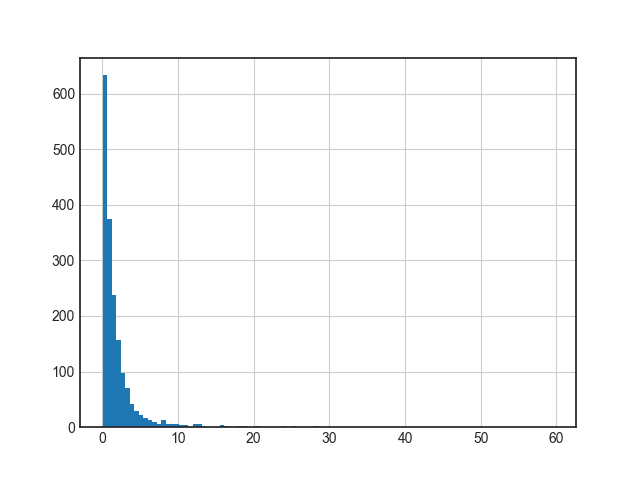

In [192]:
# Check histograms of N and duration for all events in the catalog
df.duration.hist(bins=100)

<IPython.core.display.Javascript object>


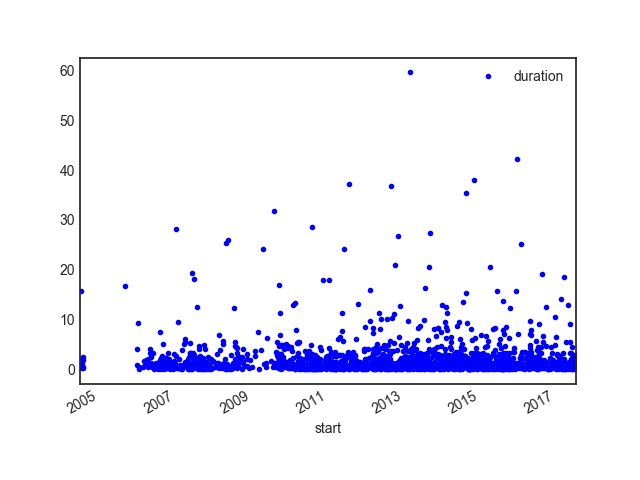

In [277]:
# Have swarms gotten longer in recent years?
df.plot.line('start','duration',style='b.')

<IPython.core.display.Javascript object>


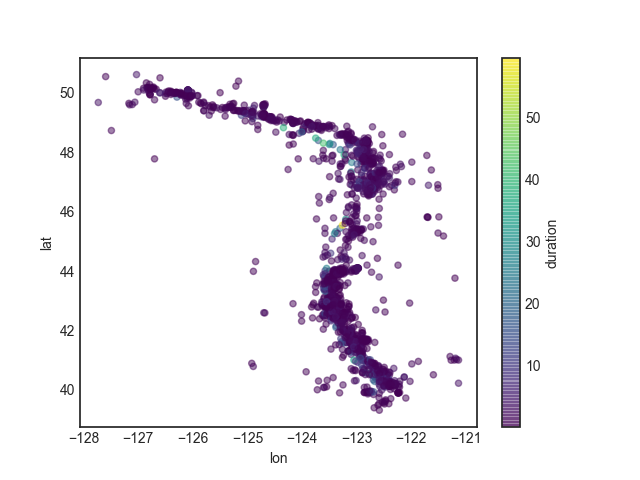

In [200]:
# Plot all the centroids, colored by duration
df.plot.scatter('lon','lat',c='duration',cmap='viridis',alpha=0.5)

In [195]:
# NOTE: array of arrays (lookup table)
ktrem = summary['ktrem'][0][0].flatten() #index for tremall array
#n = summary['n'][0][0].flatten() #matlab timestamp of each tremor event (read from DF see below)

In [246]:
tremall = mat['TREMall']
lat = tremall['lat'][0][0].flatten()
lon = tremall['lon'][0][0].flatten()
err = tremall['err'][0][0].flatten()
dep = tremall['dep'][0][0].flatten()
errdep = tremall['err_dep'][0][0].flatten()
time = vfunc(tremall['n'][0][0].flatten())

DF = pd.DataFrame(dict(lat=lat,lon=lon,err=err,dep=dep,errdep=errdep,time=time))

In [247]:
DF.head()

,dep,err,errdep,lat,lon,time
0,20.0,2.6,8.0,49.38,-125.09,2004-07-01 00:00:00.000000
1,39.0,2.9,2.8,49.45,-125.12,2004-07-01 00:19:59.999999
2,20.0,1.2,0.5,49.40,-125.10,2004-07-01 00:25:00.000001
3,40.0,4.0,0.0,49.45,-125.10,2004-07-01 00:42:29.999999
4,40.0,4.6,2.0,49.32,-125.10,2004-07-01 05:07:29.999997


In [248]:
# Consider a specific event, plot all tremor associated with that centroid
tnum = 0
inds = ktrem[tnum].flatten()

events = DF.iloc[inds]

<IPython.core.display.Javascript object>


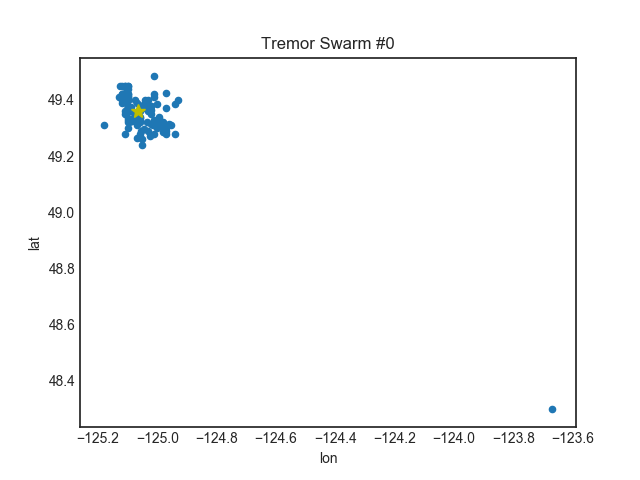

In [258]:
#Plot events colored by time
events.plot.scatter('lon','lat')
plt.plot(df.iloc[tnum].lon, df.iloc[tnum].lat,'y*',ms=10)
plt.title('Tremor Swarm #{}'.format(tnum))

<IPython.core.display.Javascript object>


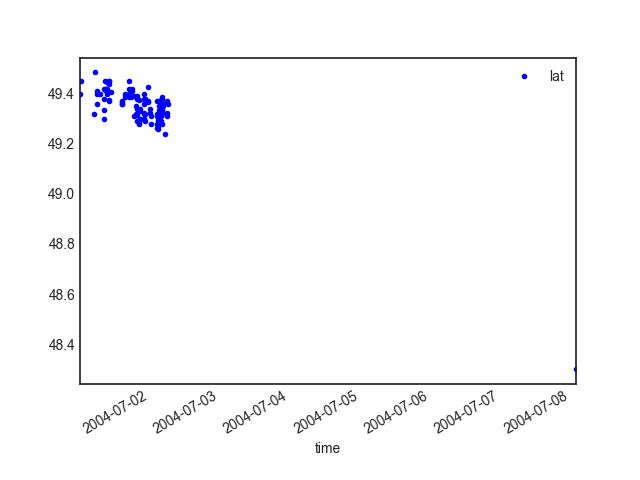

In [278]:
# Plot latitude versus time to see the rupture direction
events.plot.line('time','lat',style='b.')

# Use geopandas / shapely for advanced spatial analysis

In [299]:
# Start with centroids
geom = df.apply(lambda row: Point(row.lon, row.lat), axis=1)
gf = gpd.GeoDataFrame(df, crs="+init=epsg:4326", geometry=geom)

<IPython.core.display.Javascript object>


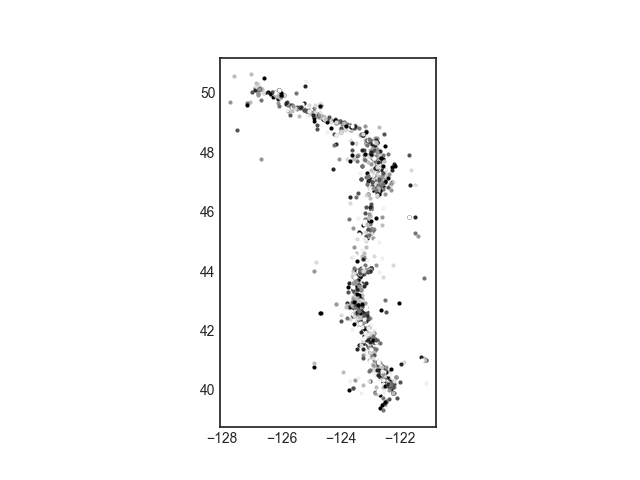

In [283]:
gf.plot() #not sure what is being used for color... probably just index?

In [300]:
# Calculate distance from specific GPS station
gps = gpd.GeoDataFrame(crs="+init=epsg:4326", geometry=[Point([236.2316,46.2074])])
gps = gps.to_crs({'init': 'epsg:32610'}) #convert to UTM first

gf = gf.to_crs({'init': 'epsg:32610'}) 
gf['distance'] = gf.distance(gps.geometry[0])/1e3 #distances in km
gf.sort_values('distance') #NOTE: could next sort by 'N' or 'duration' to hone in on large events...

,N,duration,end,hours,lat,latDev,lon,lonDev,start,geometry,distance
218,16,1.244792,2008-04-10 10:27:29.999999,1.208333,46.2900,0.0100,-123.6825,0.0775,2008-04-09 02:42:30.000002,POINT (447429.2720033556 5126495.636198665),11.317578
243,14,0.932292,2008-08-05 19:04:59.999999,1.125000,46.4100,0.0250,-123.5025,0.0925,2008-08-04 10:42:29.999996,POINT (461378.6772525874 5139725.612558262),30.430619
241,13,1.185764,2008-07-28 15:55:00.000004,0.958333,46.5100,0.1100,-123.6950,0.0450,2008-07-27 04:35:00.000002,POINT (446681.1824511223 5150949.144614771),34.095239
383,19,2.623264,2010-03-15 14:40:00.000001,1.333333,46.4800,0.0600,-123.4900,0.0300,2010-03-12 02:49:59.999996,POINT (462387.6139024156 5147497.659827751),37.101096
1554,16,1.717014,2016-05-03 17:22:30.000003,1.250000,46.1700,0.0350,-123.1500,0.0350,2016-05-01 14:34:59.999999,POINT (488420.7755995561 5112946.874464013),47.902421
1549,30,2.395833,2016-04-28 23:29:59.999997,2.125000,46.1350,0.0450,-123.1500,0.0400,2016-04-26 11:04:59.999996,POINT (488413.4332086871 5109058.030726282),48.410037
221,26,0.704861,2008-04-22 23:47:30.000004,1.958333,45.7550,0.1000,-123.7350,0.2450,2008-04-22 03:52:30.000003,POINT (442836.6210395675 5067089.560143362),50.333209
1185,250,2.595486,2014-06-30 18:57:29.999996,15.583333,45.9710,0.1235,-123.1875,0.0825,2014-06-26 04:04:59.999999,POINT (485473.8589467304 5090842.490597688),52.026189
297,17,1.546875,2009-09-14 23:02:30.000004,1.291667,46.2300,0.0600,-123.0900,0.0250,2009-09-13 01:30:00.000000,POINT (493060.0233975181 5119606.521932565),52.383652
528,27,0.756944,2011-02-15 07:07:30.000000,1.916667,46.6200,0.1200,-123.4300,0.0600,2011-02-13 02:57:29.999999,POINT (467077.9665332164 5163027.286906697),52.710186


In [287]:
gf.head()

,N,duration,end,hours,lat,latDev,lon,lonDev,start,geometry,distance
0,112,1.006944,2004-07-02 06:14:59.999997,6.458333,49.36,0.040,-125.0650,0.0350,2004-07-01 00:00:00.000000,POINT (350057.1265504275 5469527.299483799),5480.656719
1,32,1.184028,2004-07-16 20:40:00.000001,2.333333,49.61,0.030,-127.1075,0.0825,2004-07-15 12:57:29.999996,POINT (203293.6993358477 5503377.030158904),5507.075674
2,4583,15.652778,2004-07-25 10:42:29.999996,232.125000,48.40,0.215,-123.7000,0.2900,2004-07-08 01:47:29.999998,POINT (448188.2254588567 5360996.801618824),5379.633097
3,201,2.288194,2004-07-22 04:44:59.999997,13.583333,49.69,0.090,-127.0600,0.1500,2004-07-19 05:40:00.000001,POINT (207204.8729741034 5512081.11032938),5515.919215
4,11,0.234375,2004-07-24 17:45:00.000003,0.833333,47.78,0.005,-126.7000,0.0050,2004-07-24 08:34:59.999999,POINT (222843.7587102338 5298480.367165091),5303.108396


In [301]:
# Use lookup table to get polygon envelop of each event, check if GPS station within it!
# Entire catalog... warning slow. probably good to do once and save as csv for later
geom = DF.apply(lambda row: Point(row.lon, row.lat), axis=1)
GF = gpd.GeoDataFrame(DF, crs="+init=epsg:4326", geometry=geom 

GF = GF.to_crs({'init': 'epsg:32610'}) #convert to UTM first

<IPython.core.display.Javascript object>


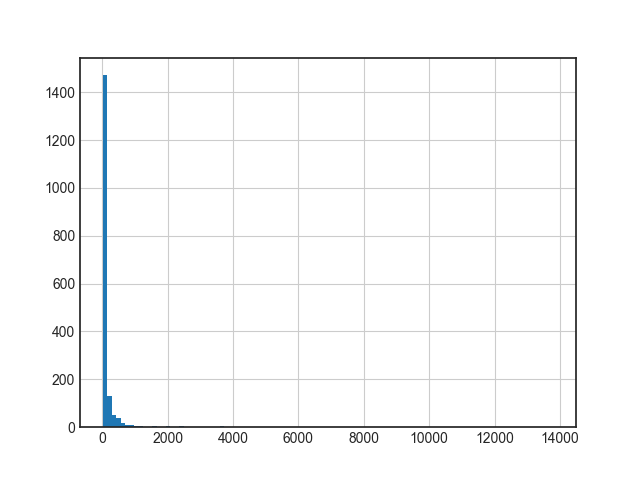

count     1793.000000
mean       202.972672
std        839.638508
min         10.000000
25%         17.000000
50%         34.000000
75%         91.000000
max      13798.000000
Name: N, dtype: float64


In [303]:
# pick a relatively large event
df.N.hist(bins=100)
print(df.N.describe())

In [304]:
bigOnes = df.query('N > 1000')
bigOnes

,N,duration,end,hours,lat,latDev,lon,lonDev,start,geometry
2,4583,15.652778,2004-07-25 10:42:29.999996,232.125000,48.4000,0.2150,-123.700,0.290,2004-07-08 01:47:29.999998,POINT (-123.7 48.4)
9,2849,16.661458,2005-09-23 15:14:59.999997,166.083333,48.2600,0.1800,-123.430,0.280,2005-09-03 00:57:29.999996,POINT (-123.43 48.26)
100,7853,28.159722,2007-02-18 14:40:00.000001,396.125000,47.3400,0.4850,-123.100,0.175,2007-01-09 10:17:30.000004,POINT (-123.1 47.34)
102,1064,9.409722,2007-02-06 15:00:00.000000,59.208333,44.6000,0.1100,-123.475,0.080,2007-01-26 19:15:00.000003,POINT (-123.475 44.6)
144,2576,19.300347,2007-07-05 00:05:00.000002,139.500000,45.4400,0.2800,-123.305,0.125,2007-06-07 07:02:29.999998,POINT (-123.305 45.44)
146,2455,18.121528,2007-07-16 17:34:59.999999,140.166667,43.3350,0.1950,-123.590,0.090,2007-06-25 11:42:30.000002,POINT (-123.59 43.335)
182,1158,4.062500,2007-10-16 01:37:30.000003,61.166667,48.0500,0.1500,-122.990,0.090,2007-10-11 00:02:30.000001,POINT (-122.99 48.05)
210,1248,6.890625,2008-03-09 21:27:30.000002,69.458333,47.4720,0.0880,-122.850,0.095,2008-02-28 08:54:59.999998,POINT (-122.85 47.472)
228,8012,25.406250,2008-06-02 11:07:29.999997,401.708333,47.6600,0.4350,-123.090,0.160,2008-04-27 03:02:30.000001,POINT (-123.09 47.66)
230,2049,25.939236,2008-06-16 20:37:30.000000,124.625000,44.0900,0.3350,-123.550,0.100,2008-05-18 02:20:00.000002,POINT (-123.55 44.09)


In [311]:
tnum = 2
inds = ktrem[tnum].flatten()
events = GF.iloc[inds]
print(len(events))

4583


In [313]:
#http://portolan.leaffan.net/creating-sample-points-with-ogr-and-shapely-pt-1-centroids-and-representative-points/
#events.convex_hull.plot() taking convex hull of each point for some reason
events.head()

,dep,err,errdep,lat,lon,time,geometry
113,25.0,0.8,0.0,48.29,-123.66,2004-07-08 01:49:59.999999,POINT (451043.6467642962 5348743.837298804)
114,27.0,0.2,0.0,48.30,-123.72,2004-07-08 02:02:30.000004,POINT (446603.5231171814 5349895.356411693)
115,31.0,1.8,0.0,48.29,-123.76,2004-07-08 02:04:59.999996,POINT (443626.0635407736 5348812.459273366)
116,32.0,3.9,0.0,48.24,-123.71,2004-07-08 02:07:29.999997,POINT (447283.4590097263 5343219.438185696)
117,23.0,0.4,0.0,48.28,-123.75,2004-07-08 02:09:59.999998,POINT (444356.9596978286 5347693.659029125)


<IPython.core.display.Javascript object>


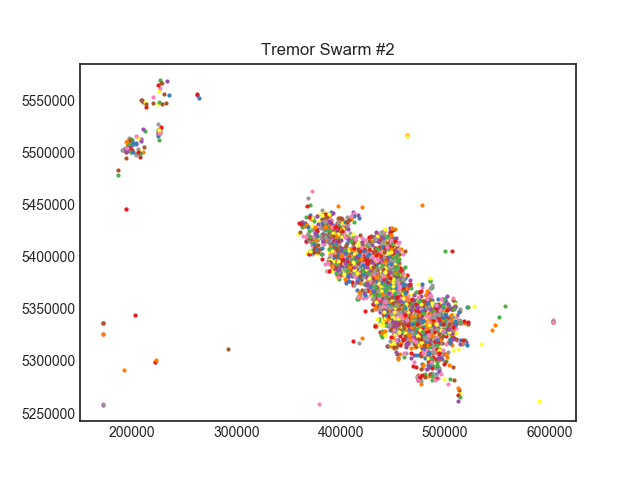

In [315]:
#Plot events colored by time
events.geometry.plot()
#plt.plot(df.iloc[tnum].lon, df.iloc[tnum].lat,'y*',ms=10)
plt.title('Tremor Swarm #{}'.format(tnum))

In [ ]:
# Ideas: 1) crop based on distance from epicenter
# 2)* Use standard multivariate statistics to draw confidence ellipse.
#https://gis.stackexchange.com/questions/243459/drawing-ellipse-with-shapely/243462
#https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipses-in-a-sccatterplot-using-matplotlib